In [10]:
import pandas as pd
import os
import geopandas as gpd
import geojson
import networkx as nx
import csv
import numpy as np
import os
from tqdm import tqdm
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
from datetime import datetime

In [65]:
disp_data = pd.read_excel(r'/home/sara/Documenti/GitHub/Climate-and-conflict/displacements/UNHCR-PRMN-Displacement-Dataset - Somalia.xlsx')
disp_data = disp_data[(disp_data['Reason']=='Drought related') | (disp_data['Reason']=='Flood')]

In [66]:
disp_data.head()

,Month End,Year Week,Current (Arrival) Region,Current (Arrival) District,Previous (Departure) Region,Previous (Departure) District,Reason,Current (Arrival) Priority Need,Number of Individuals
0,30/04/2016,201614,Awdal,Borama,Awdal,Borama,Drought related,Food,6
1,30/04/2016,201617,Awdal,Borama,Awdal,Borama,Drought related,Livelihood Support,7
2,30/04/2016,201616,Awdal,Borama,Awdal,Borama,Flood,Food,5
3,30/04/2016,201614,Awdal,Borama,Awdal,Lughaye,Drought related,Food,8
4,31/03/2016,201611,Awdal,Borama,Awdal,Lughaye,Drought related,Food,9


In [67]:
v= disp_data["Month End"]
v=v.values
dt = [datetime.strptime(v[i], "%d/%m/%Y") for i in range(len(v))]
q=[]
for i in range(len(dt)):
    q.append(datetime.timestamp(dt[i])) 
disp_data.insert(loc=3, column='date_timestamp', value=q)
disp_data = disp_data.sort_values("date_timestamp")
disp_data['Month End'] = pd.to_datetime(disp_data['Month End'], dayfirst=True)

aggregated_data = disp_data.groupby([pd.Grouper(key='Month End', freq='M'),'Previous (Departure) District', 'Current (Arrival) District'])['Number of Individuals'].sum().to_frame()
dates = aggregated_data.index.get_level_values('Month End').unique()
districts = aggregated_data.index.get_level_values('Previous (Departure) District').unique()
all_combinations = pd.MultiIndex.from_product([dates, districts, districts], names=['time', 'Previous (Departure) District','Current (Arrival) District'])
disp_data1 = aggregated_data.reindex(all_combinations, fill_value=0).reset_index() 

disp_matxs = disp_data1.pivot_table(index=['time','Previous (Departure) District'], columns='Current (Arrival) District', values='Number of Individuals', aggfunc='sum')
disp_matxs['year'] = disp_matxs.index.get_level_values('time').year

In [69]:
# initialize empty lists to store the degree and self weight arrays
df_national_list = []
df_stats_list = []

# loop over the files in the directory
for f, time in tqdm(enumerate(disp_data1['time'].unique())):
 
    df = disp_data1[disp_data1['time']==time]

    G = nx.from_pandas_edgelist(df, source='Previous (Departure) District', target='Current (Arrival) District', 
                    edge_attr=['Number of Individuals'], create_using=nx.MultiDiGraph())

    nodes = list(nx.nodes(G))
    in_degrees_dict=dict(G.in_degree(weight='Number of Individuals'))
    in_degrees = list(in_degrees_dict.values())
    out_degrees_dict=dict(G.out_degree(weight='Number of Individuals'))
    out_degrees = list(out_degrees_dict.values())
    OD = nx.adjacency_matrix(G, weight='Number of Individuals')
    OD_arr = OD.toarray()
    nan_one=np.empty(1)
    nan_one[:]=np.nan
    self_weight = [np.divide(OD_arr[i, i], np.sum(OD_arr[i]), out=nan_one, where=not(np.isnan(np.sum(OD_arr[i])) or np.sum(OD_arr[i])==0))[0] for i in range(len(OD_arr))]

    # calculate the mean and quantiles of the degree and self weight arrays
    mean_degree = np.nanmean(in_degrees)
    in_degree_quantiles = np.nanquantile(in_degrees, [0.025, 0.5, 0.975])
    out_degree_quantiles = np.nanquantile(out_degrees, [0.025, 0.5, 0.975])

    mean_self_weight = np.nanmean(self_weight)
    self_weight_quantiles = np.nanquantile(self_weight, [0.025, 0.5, 0.975])
    
    # append the degree and self weight arrays and their quantiles to the lists
    date_list=[time]*len(nodes)
    df_national=pd.DataFrame({'date':time, 'mean_degree': mean_degree, 'mean_self_weight': mean_self_weight, 'in_degree_lower': in_degree_quantiles[0], 'in_degree_median': in_degree_quantiles[1], 'in_degree_upper': in_degree_quantiles[2], 'out_degree_lower': out_degree_quantiles[0], 'out_degree_median': out_degree_quantiles[1], 'out_degree_upper': out_degree_quantiles[2], 'self_weight_lower': self_weight_quantiles[0],'self_weight_median': self_weight_quantiles[1],'self_weight_upper': self_weight_quantiles[2]}, index=[0])
    df_national_list.append(df_national)
    df_stats = pd.DataFrame({'date':date_list,'geoid': nodes, 'in_degree': in_degrees, 'out_degree': out_degrees,'self_weight': self_weight})
    df_stats_list.append(df_stats)

0it [00:00, ?it/s]

92it [00:03, 24.43it/s]


In [ ]:
#with open('/data/shared/Lagrange72/code/stefi_sara/df_stats_list.pkl', 'wb') as f:
 #   pkl.dump(df_stats_list, f)
#with open('/data/shared/Lagrange72/code/stefi_sara/df_national_list.pkl', 'wb') as f:
 #   pkl.dump(df_national_list, f)

In [ ]:
#with open('/data/shared/Lagrange72/code/stefi_sara/df_stats_list_daily.pkl', 'rb') as f:
 #   df_stats_list = pkl.load(f)
#with open('/data/shared/Lagrange72/code/stefi_sara/df_national_list_daily.pkl', 'rb') as f:
 #   df_national_list = pkl.load(f)

In [70]:
df_stats = pd.concat(df_stats_list)
#df_stats['date'] = df_stats['date'].str.replace('_', '-')
df_stats['date'] = pd.to_datetime(df_stats['date'])
df_national = df_stats.groupby('date').agg({'in_degree': 'mean', 'out_degree': 'mean', 'self_weight': 'mean'})
df_national = df_national.reset_index()

## Plot national averages

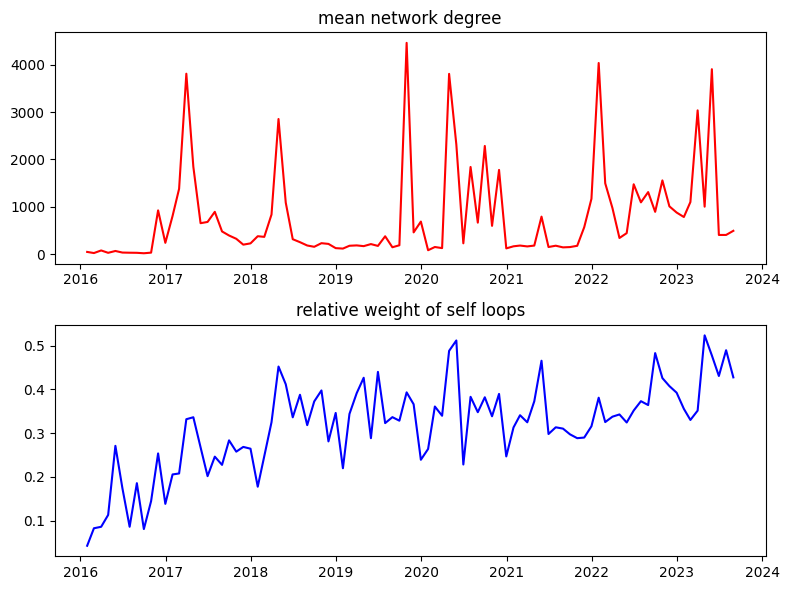

In [71]:
# plot the in degree and self weight arrays for the first file in the directory
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
palette=['r','blue']

dates = df_stats['date'].unique()
ax[0].plot(dates,df_national['in_degree'],color=palette[0])
ax[0].set_title('mean network degree')
ax[1].plot(dates,df_national['self_weight'],color=palette[1])
ax[1].set_title('relative weight of self loops')

fig.tight_layout()

## Plot some counties for fun

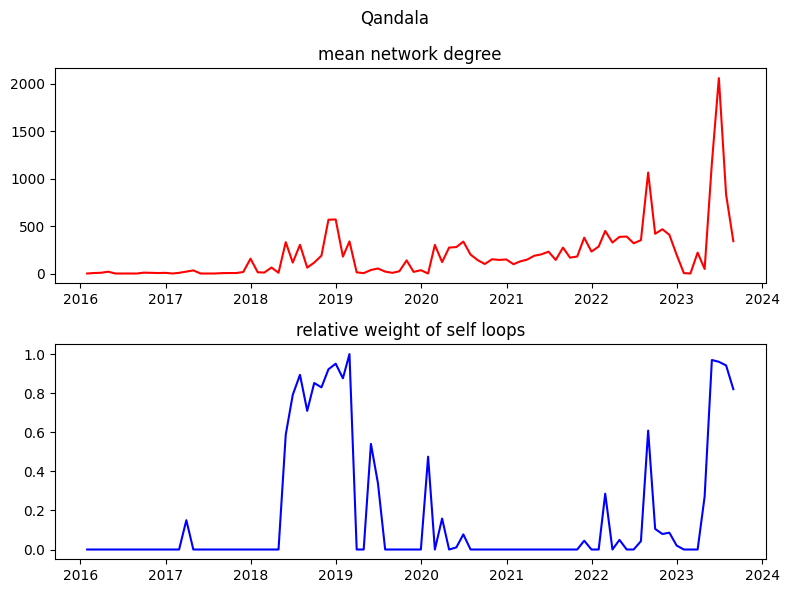

In [72]:
random_county=df_stats['geoid'].sample(1).values[0]
df_stats_county=df_stats[df_stats['geoid']==random_county]
df_stats_county=df_stats_county.sort_values(by='date')

# plot the in degree and self weight arrays for a random county
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot(df_stats_county['date'],df_stats_county['out_degree'],color=palette[0])
ax[0].set_title('mean network degree')
ax[1].plot(df_stats_county['date'],df_stats_county['self_weight'],color=palette[1])
ax[1].set_title('relative weight of self loops')
fig.suptitle(random_county)
fig.tight_layout()

## Plot by state

In [62]:
#aggregate by state
cont = gpd.read_file(r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/som_adm_ocha_itos_20230308_shp/som_admbnda_adm1_ocha_20230308.shp")
cont.head()

,Shape_Leng,Shape_Area,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,geometry
0,5.657071,1.312224,Awdal,SO11,Somalia,SO,2022-12-21,2023-03-08,NaN,"MULTIPOLYGON (((43.46189 11.42429, 43.45532 11..."
1,6.650225,2.101389,Bakool,SO25,Somalia,SO,2022-12-21,2023-03-08,NaN,"POLYGON ((44.03028 4.95968, 44.08498 4.95730, ..."
2,1.068762,0.026612,Banadir,SO22,Somalia,SO,2022-12-21,2023-03-08,NaN,"POLYGON ((45.55389 2.15350, 45.55328 2.15308, ..."
3,12.218762,5.618064,Bari,SO16,Somalia,SO,2022-12-21,2023-03-08,NaN,"POLYGON ((50.79877 11.98356, 50.80576 11.97939..."
4,8.086913,3.572929,Bay,SO24,Somalia,SO,2022-12-21,2023-03-08,NaN,"POLYGON ((44.31110 3.57147, 44.31110 3.55957, ..."


In [73]:
disp_data.head()

,Month End,Year Week,Current (Arrival) Region,date_timestamp,Current (Arrival) District,Previous (Departure) Region,Previous (Departure) District,Reason,Current (Arrival) Priority Need,Number of Individuals
2698,2016-01-31,201604,Woqooyi Galbeed,1.454195e+09,Hargeysa,Middle Shabelle,Cadale,Drought related,Food,6
2129,2016-01-31,201603,Mudug,1.454195e+09,Gaalkacyo,Mudug,Hobyo,Drought related,Humanitarian Aid,187
2125,2016-01-31,201604,Mudug,1.454195e+09,Gaalkacyo,Mudug,Hobyo,Drought related,Health,765
2124,2016-01-31,201603,Mudug,1.454195e+09,Gaalkacyo,Mudug,Hobyo,Drought related,Health,240
2123,2016-01-31,201601,Mudug,1.454195e+09,Gaalkacyo,Mudug,Hobyo,Drought related,Health,216


In [87]:
reg_state = disp_data[['Previous (Departure) District','Previous (Departure) Region']]

#remove duplicates from reg_state
reg_state = reg_state.drop_duplicates('Previous (Departure) District', keep='first')
reg_state

,Previous (Departure) District,Previous (Departure) Region
2698,Cadale,Middle Shabelle
2129,Hobyo,Mudug
2099,Gaalkacyo,Mudug
2030,Jalalaqsi,Hiraan
1996,Belet Weyne,Hiraan
...,...,...
193,Doolow,Gedo
6110,Wanla Weyn,Lower Shabelle
11342,Dhahar,Sanaag
11339,Badhan,Sanaag


In [88]:
df_stats

,date,geoid,in_degree,out_degree,self_weight
0,2016-01-31,Baardheere,0,216,0.000000
1,2016-01-31,Baidoa,114,43,0.674419
2,2016-01-31,Balcad,0,11,0.000000
3,2016-01-31,Banadir,0,175,0.000000
4,2016-01-31,Baraawe,0,128,0.000000
...,...,...,...,...,...
72,2023-08-31,Doolow,658,0,0.916667
73,2023-08-31,Wanla Weyn,0,974,0.000000
74,2023-08-31,Badhan,0,115,0.000000
75,2023-08-31,Dhahar,0,265,0.000000


In [97]:
df_merged = pd.merge(df_stats, reg_state, left_on=['geoid'], right_on=['Previous (Departure) District'], how='left')
df_agg = df_merged.groupby(['geoid', 'date']).agg({'in_degree': 'mean', 'out_degree': 'mean', 'self_weight': 'mean'})
df_agg.reset_index(inplace=True)
df_agg['date']=pd.to_datetime(df_agg['date'])

In [102]:
df_merged

,date,geoid,in_degree,out_degree,self_weight,Previous (Departure) District,Previous (Departure) Region
0,2016-01-31,Baardheere,0,216,0.000000,Baardheere,Gedo
1,2016-01-31,Baidoa,114,43,0.674419,Baidoa,Bay
2,2016-01-31,Balcad,0,11,0.000000,Balcad,Middle Shabelle
3,2016-01-31,Banadir,0,175,0.000000,Banadir,Banadir
4,2016-01-31,Baraawe,0,128,0.000000,Baraawe,Lower Shabelle
...,...,...,...,...,...,...,...
7079,2023-08-31,Doolow,658,0,0.916667,Doolow,Gedo
7080,2023-08-31,Wanla Weyn,0,974,0.000000,Wanla Weyn,Lower Shabelle
7081,2023-08-31,Badhan,0,115,0.000000,Badhan,Sanaag
7082,2023-08-31,Dhahar,0,265,0.000000,Dhahar,Sanaag


In [98]:
df_agg['internal mobility'] = df_agg['self_weight']*df_agg['out_degree']
df_agg['external mobility out'] = df_agg['out_degree'] - df_agg['internal mobility']
df_agg['external mobility in'] = df_agg['in_degree'] - df_agg['internal mobility']
df_agg['external mobility total'] = df_agg['external mobility out'] + df_agg['external mobility in']

In [100]:
# find starting date of the stringency index
# start_date=pd.to_datetime('2020-01-01')
# end_date=pd.to_datetime('2021-04-28')
# df_agg1_cut=df_agg1[(df_agg1['date']>=start_date) & (df_agg1['date']<=end_date)]
# df_agg1_cut=df_agg1_cut.sort_values(by='date')
# df_agg1_cut=df_agg1_cut.reset_index(drop=True)

## Plot in and out degree for each subregion

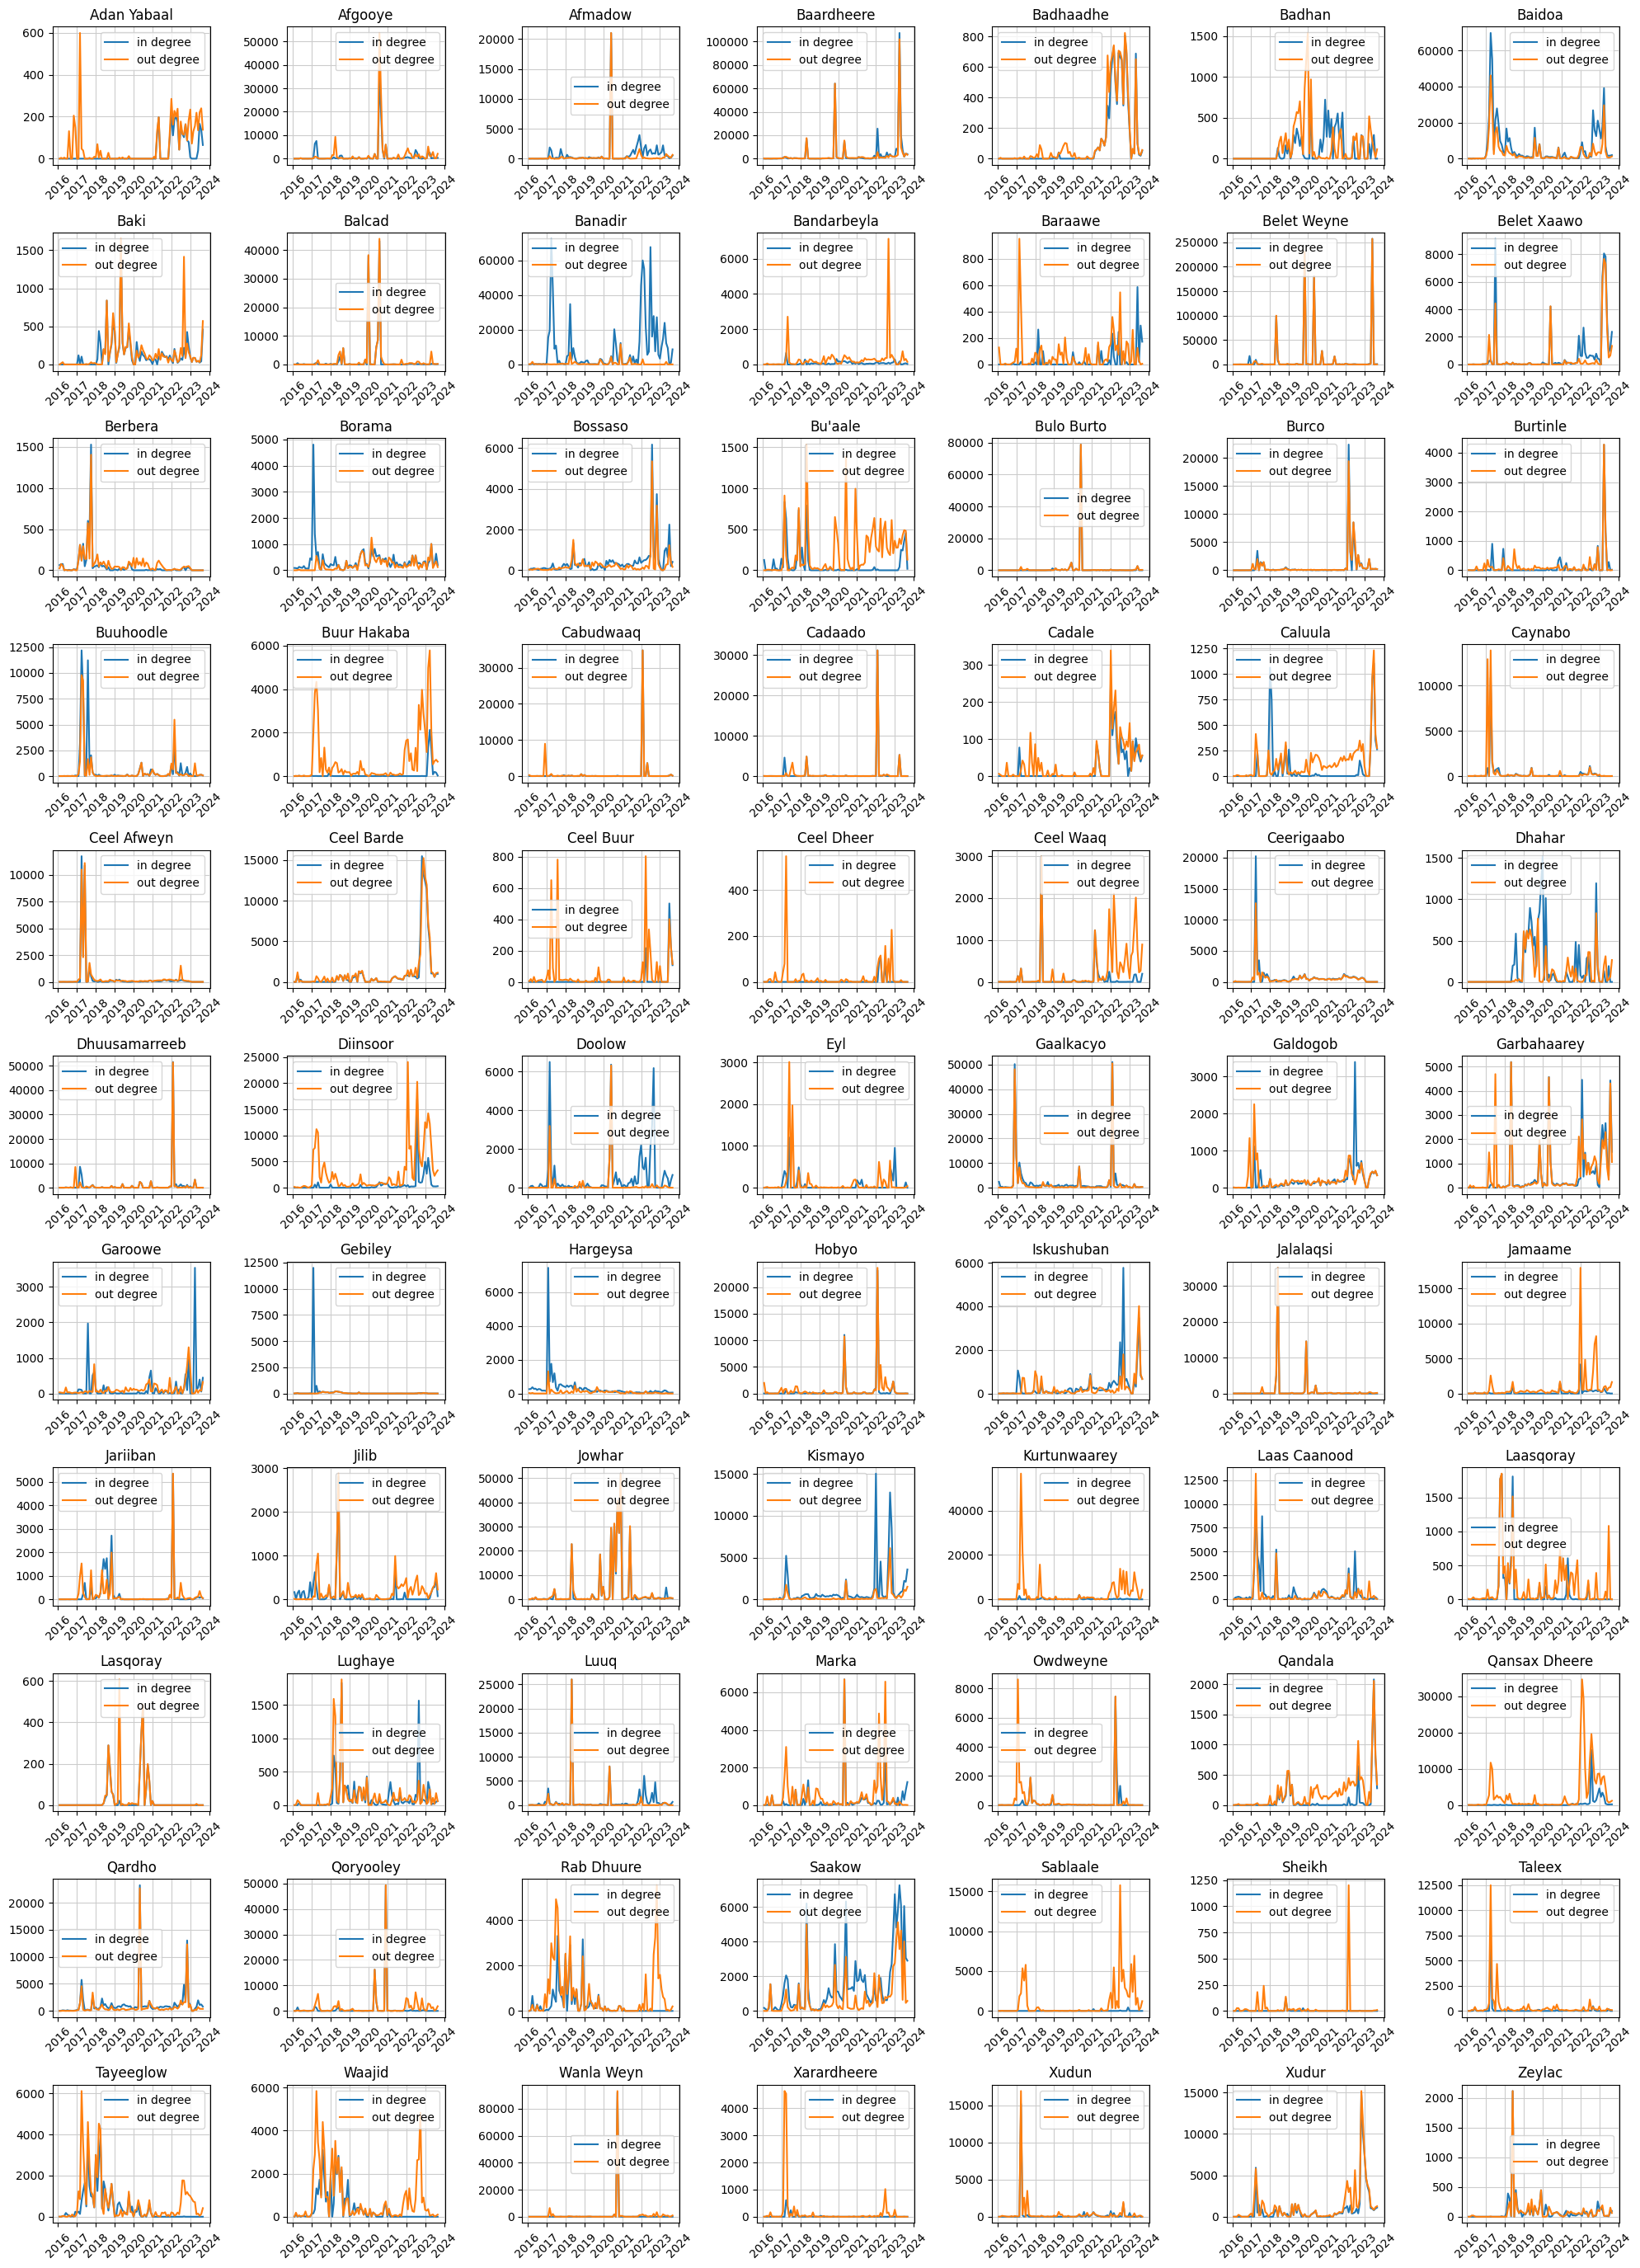

In [95]:
# create a figure with subplots
fig, axes = plt.subplots(11, 7, figsize=(20, 30))
ax = axes.flatten()
states = df_agg['geoid'].unique()
# iterate over the states
for i, state in zip(range(len(states)), states):

    df_agg_state = df_agg[df_agg['geoid']==state]
    # plot value of stringency index for each date
    ax[i].plot(df_agg_state['date'], df_agg_state['in_degree'], label='in degree')
    ax[i].plot(df_agg_state['date'], df_agg_state['out_degree'], label='out degree')  
    
    ax[i].tick_params(axis='x', rotation=45)

    # add a grid
    ax[i].grid(True, color = '0.8', which='major')
    ax[i].grid(True, color = '0.8', alpha = 0.5, which='minor', linestyle='--')

    ax[i].legend()
    # set state name as title
    ax[i].set_title(state)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [101]:
df_agg

,geoid,date,in_degree,out_degree,self_weight,internal mobility,external mobility out,external mobility in,external mobility total
0,Adan Yabaal,2016-01-31,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
1,Adan Yabaal,2016-02-29,0.0,4.0,0.00000,0.0,4.0,0.0,4.0
2,Adan Yabaal,2016-03-31,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
3,Adan Yabaal,2016-04-30,0.0,5.0,0.00000,0.0,5.0,0.0,5.0
4,Adan Yabaal,2016-05-31,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
7079,Zeylac,2023-04-30,12.0,12.0,1.00000,12.0,0.0,0.0,0.0
7080,Zeylac,2023-05-31,11.0,21.0,0.52381,11.0,10.0,0.0,10.0
7081,Zeylac,2023-06-30,8.0,8.0,1.00000,8.0,0.0,0.0,0.0
7082,Zeylac,2023-07-31,74.0,153.0,0.48366,74.0,79.0,0.0,79.0


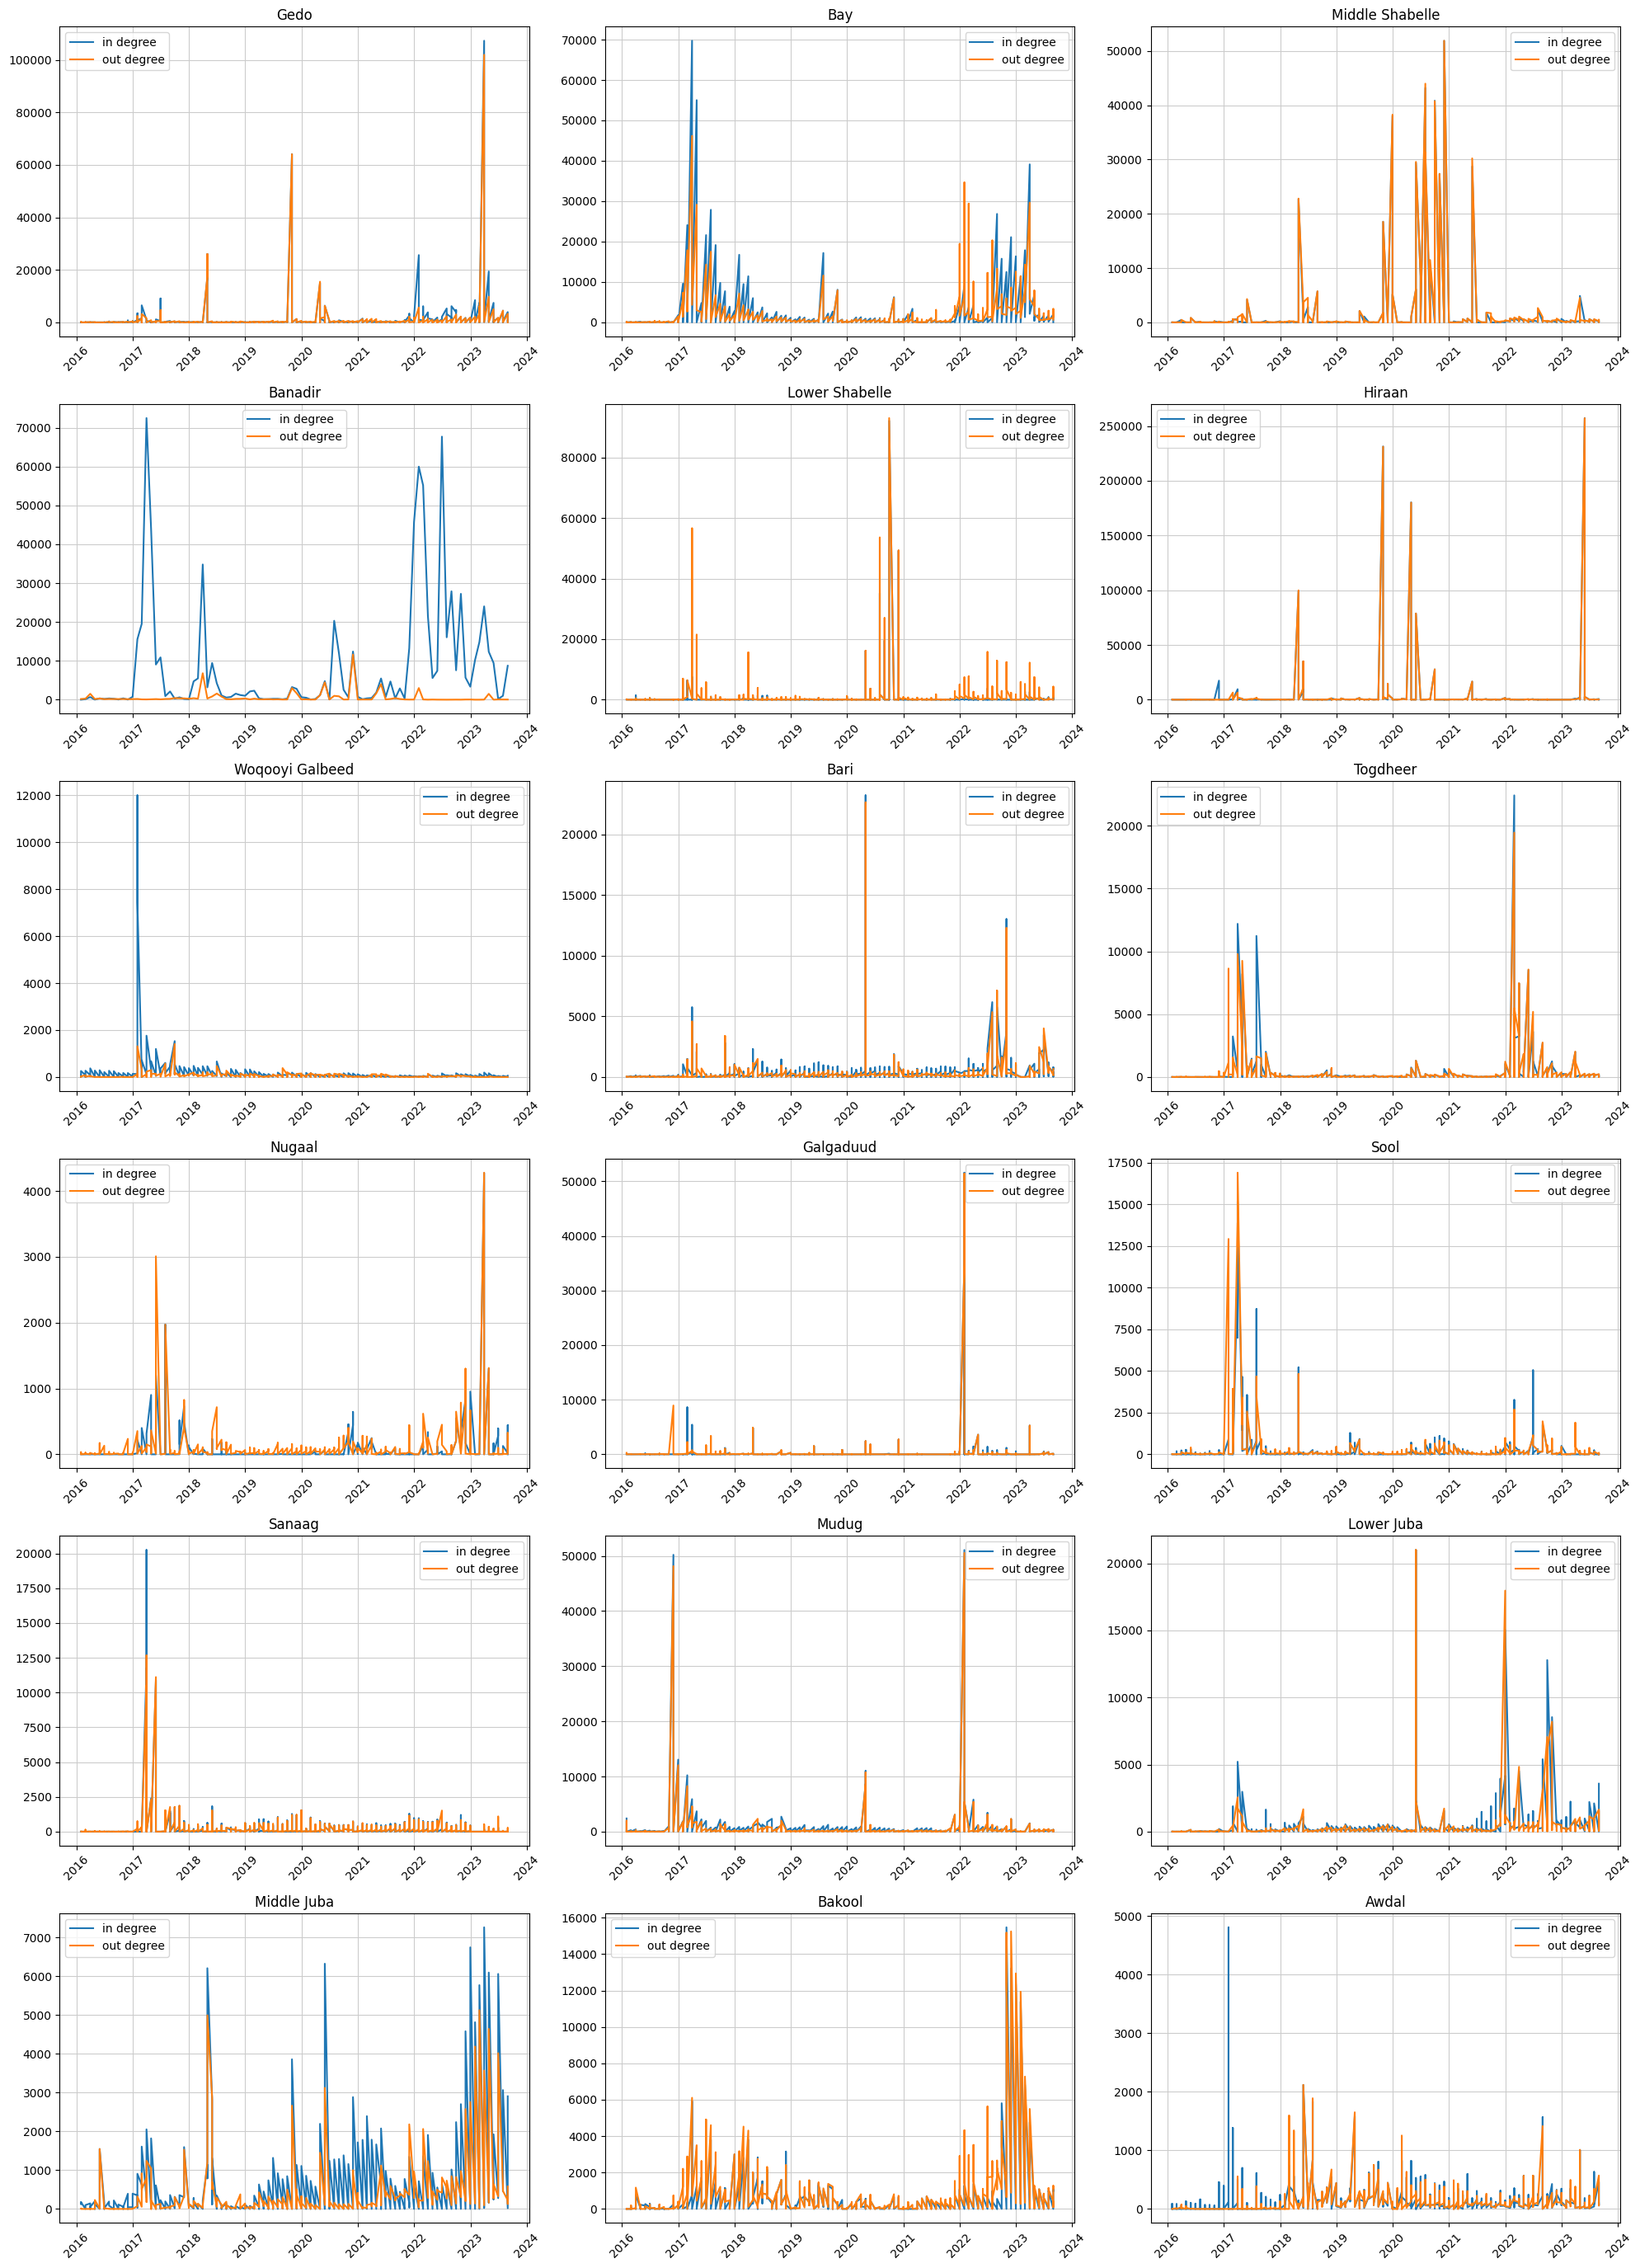

In [106]:
# create a figure with subplots
fig, axes = plt.subplots(6, 3, figsize=(20, 30))
ax = axes.flatten()
states = df_merged['Previous (Departure) Region'].unique()
# iterate over the states
for i, state in zip(range(len(states)), states):

    df_agg_state = df_merged[df_merged['Previous (Departure) Region']==state]
    # plot value of stringency index for each date
    ax[i].plot(df_agg_state['date'], df_agg_state['in_degree'], label='in degree')
    ax[i].plot(df_agg_state['date'], df_agg_state['out_degree'], label='out degree')  
    
    ax[i].tick_params(axis='x', rotation=45)

    # add a grid
    ax[i].grid(True, color = '0.8', which='major')
    ax[i].grid(True, color = '0.8', alpha = 0.5, which='minor', linestyle='--')

    ax[i].legend()
    # set state name as title
    ax[i].set_title(state)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()